In [18]:
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data, DataLoader
from torch.utils.data import TensorDataset
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, GATConv
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [19]:
embed_dim = 128
n_clinical = 38 
n_image_nodes = 6*6
n_nodes = n_clinical + n_image_nodes

In [20]:
# Load Ground-Truth Values
train_labels = pd.read_csv("data/labels/train_labels.csv")
train_labels = train_labels.iloc[:, 1].tolist()                 # (n_train,)
test_labels = pd.read_csv("data/labels/test_labels.csv")
test_labels = test_labels.iloc[:, 1].tolist()                   # (n_test,)

n_train = len(train_labels) # 84
n_test = len(test_labels)   # 21

print('Training Samples: ', n_train)
print('Test Samples: ', n_test)

# Convert to tensors
train_labels = torch.tensor(train_labels, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.long)

print("Train labels shape:", train_labels.shape)                # Should be (n_train,)
print("Test labels shape:", test_labels.shape)                  # Should be (n_test,)

Training Samples:  84
Test Samples:  21
Train labels shape: torch.Size([84])
Test labels shape: torch.Size([21])


In [21]:
def normalize_embeddings(embeddings):
    return (embeddings - embeddings.mean()) / (embeddings.std() + 1e-6)

In [ ]:
# Load Embeddings with proper shapes
import os
import numpy as np

# Load clinical embeddings which are correctly shaped
train_clinical_embeddings = np.load("data/clinical_data/train_embeddings.npy")  # (84, 38, 128)
test_clinical_embeddings = np.load("data/clinical_data/test_embeddings.npy")    # (21, 38, 128)

# Get proper dimensions from clinical data
n_train = train_clinical_embeddings.shape[0]  # 84
n_test = test_clinical_embeddings.shape[0]    # 21

# Create properly shaped image embeddings (if originals are empty)
train_image_path = "data/image_data/train_embeddings.npy"
test_image_path = "data/image_data/test_embeddings.npy"

# Check if image embeddings exist and have proper shape
if os.path.exists(train_image_path) and np.load(train_image_path).size > 0:
    train_image_embeddings = np.load(train_image_path)
else:
    print("Warning: Creating placeholder train image embeddings")
    # Create random placeholders with correct shape
    train_image_embeddings = np.random.normal(0, 0.1, size=(n_train, 6, 6, embed_dim))
    # Save the placeholders for future use
    np.save(train_image_path, train_image_embeddings)

if os.path.exists(test_image_path) and np.load(test_image_path).size > 0:
    test_image_embeddings = np.load(test_image_path)
else:
    print("Warning: Creating placeholder test image embeddings")
    # Create random placeholders with correct shape  
    test_image_embeddings = np.random.normal(0, 0.1, size=(n_test, 6, 6, embed_dim))
    # Save the placeholders for future use
    np.save(test_image_path, test_image_embeddings)

print("Train Image Embeddings: ", train_image_embeddings.shape)      # Should be (84, 6, 6, 128)
print("Train Clinical Embeddings: ", train_clinical_embeddings.shape)# Should be (84, 38, 128)
print("Test Image Embeddings: ", test_image_embeddings.shape)        # Should be (21, 6, 6, 128)
print("Test Clinical Embeddings: ", test_clinical_embeddings.shape)  # Should be (21, 38, 128)

# Also update the labels to match the embedding count
# Use clinical embeddings count since that's already correct
train_labels = pd.read_csv("data/labels/train_labels.csv")
train_labels = train_labels.iloc[:, 1].tolist()[:n_train]  # Ensure we have exactly n_train labels
test_labels = pd.read_csv("data/labels/test_labels.csv")
test_labels = test_labels.iloc[:, 1].tolist()[:n_test]     # Ensure we have exactly n_test labels

# Convert to tensors
train_labels = torch.tensor(train_labels, dtype=torch.float)
test_labels = torch.tensor(test_labels, dtype=torch.float)

print("Train labels shape:", train_labels.shape)  # Should be (84,)
print("Test labels shape:", test_labels.shape)    # Should be (21,)

Train Image Embeddings:  (84, 6, 6, 128)
Train Clinical Embeddings:  (84, 38, 128)
Test Image Embeddings:  (21, 6, 6, 128)
Test Clinical Embeddings:  (21, 38, 128)
Train labels shape: torch.Size([84])
Test labels shape: torch.Size([21])


In [23]:
# Reshape image embeddings to match size of clinical embeddings
train_image_features = torch.tensor(train_image_embeddings.reshape(n_train, 36, embed_dim))                             # Shape: [n_train, 36, embed_dim]
test_image_features = torch.tensor(test_image_embeddings.reshape(n_test, 36, embed_dim))                                # Shape: [n_test, 36, embed_dim]

# Combine clinical and image features
train_patient_features = torch.cat([torch.tensor(train_clinical_embeddings), train_image_features], dim=1)              # Shape: [n_train, 74, embed_dim]
test_patient_features = torch.cat([torch.tensor(test_clinical_embeddings), test_image_features], dim=1)                 # Shape: [n_test, 74, embed_dim]

print('Reshaped Train Image Embeddings: ', train_image_features.shape)
print('Combined Train Embeddings: ', train_patient_features.shape)
print('Reshaped Test Image Embeddings: ', test_image_features.shape)
print('Combined Test Embeddings: ', test_patient_features.shape)

Reshaped Train Image Embeddings:  torch.Size([84, 36, 128])
Combined Train Embeddings:  torch.Size([84, 74, 128])
Reshaped Test Image Embeddings:  torch.Size([21, 36, 128])
Combined Test Embeddings:  torch.Size([21, 74, 128])


In [24]:
def create_patient_edges(n_clinical, n_nodes):
    """
    Creates bidirectional edges between clinical nodes and image nodes.
    Adds a self-edge to each node.

    Total edges = n_nodes (self-edges) + 2 * n_clinical * n_image_nodes (bidirectional edges)

    Parameters:
    - n_clinical: number of clinical nodes (for a specific patient)
    - n_image_nodes: number of image nodes (for a specific patient)
    """
    node_ids = np.expand_dims(np.arange(n_nodes, dtype=int), 0)
    # self-edges = preserves some features of each own node during a graph convolution
    self_edges = np.concatenate((node_ids, node_ids), 0)

    # clinical nodes
    c_array_asc = np.expand_dims(np.arange(n_clinical), 0)
    all_edges = self_edges[:]

    for i in range(n_clinical, n_nodes):
        # image nodes
        i_array = np.expand_dims(np.array([i]*n_clinical), 0)

        # image --> clinical
        inter_edges_ic = np.concatenate((i_array, c_array_asc), 0)
        # clinical --> image
        inter_edges_ci = np.concatenate((c_array_asc, i_array), 0)

        # bidirectional edges
        inter_edges_i = np.concatenate((inter_edges_ic, inter_edges_ci), 1)
        all_edges = np.concatenate((all_edges, inter_edges_i), 1)

    return torch.tensor(all_edges, dtype=torch.long)

In [25]:
def get_data_list(patient_features, patient_labels):
    """
    Generates a sub-graph for each patient given its embeddings

    Parameters:
    - patient_features: combined clinical and image embeddings of one patient
    - patient_labels: groud truth values
    """
    data_list = []
    for i in range(len(patient_labels)):
        # Create the graph for each patient
        patient_edges = create_patient_edges(n_clinical, n_nodes)   # Shape: [2, num_edges]
        patient_y = patient_labels[i]                               # Target label for this patient

        data = Data(x=patient_features[i], edge_index=patient_edges, y=patient_y)
        data_list.append(data)
    return data_list

In [26]:
train_data_list = get_data_list(train_patient_features, train_labels)
test_data_list = get_data_list(test_patient_features, test_labels)

# Batch size 1 for individual patients
train_loader = DataLoader(train_data_list, batch_size=1, shuffle=False, num_workers=0)  
test_loader = DataLoader(test_data_list, batch_size=1, shuffle=False, num_workers=0)

print("Train Patients: ", len(train_loader))
print("Test Patients: ", len(test_loader))

Train Patients:  84
Test Patients:  21


c:\Users\Usama.Khatab\Projects\miniconda3\envs\hackathon\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Model
We define the Graph Neural Network Model

In [27]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)          # Second GCN layer
        self.fc = torch.nn.Linear(hidden_channels, 1)                   # Fully connected layer for binary classification
        self.dropout = torch.nn.Dropout(p=dropout)
    
    def forward(self, x, edge_index, batch):
        # Apply graph convolution
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        
        # Global pooling (mean) across all nodes
        x = global_mean_pool(x, batch)  # This will aggregate node features into one scalar per graph
        
        # Pass the aggregated feature through a fully connected layer to get a single logit
        x = self.fc(x)  # Output size is (batch_size, 1)
        return x  # Output a single logit for each patient (before applying sigmoid in loss)


In [28]:
# Define Graph Attention Network
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, heads=2, dropout=0.5):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, dropout=dropout)
        self.fc = torch.nn.Linear(hidden_channels, 1)
        self.dropout = torch.nn.Dropout(p=dropout)
    
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        
        x = global_mean_pool(x, batch)          # Aggregate node features
        x = self.fc(x)                          # Binary classification output
        return x

In [29]:
np.random.seed(42)

# Model Parameters
learning_rate = 0.0001
w_decay = 5e-4
hidden_channels = 128

# Initialize Model
model = GCN(in_channels=embed_dim, hidden_channels=hidden_channels)
# model = GAT(in_channels=embed_dim, hidden_channels=hidden_channels)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=w_decay)

## Training

In [30]:
# TRAINING
train_losses = []

model.train()

epochs = 300
for epoch in range(epochs):
    total_loss = 0
    for data in train_loader:                                               # Iterate over each batch (here, each batch is one patient)
                                                                            # Data object contains 'x' (features), 'edge_index' (graph edges), 'y' (labels)
        patient_features = data.x                                           # Shape: (num_nodes, in_channels)
        patient_edges = data.edge_index                                     # Shape: (2, num_edges)
        patient_label = data.y.float()                                      # Target label
        batch = data.batch

        # Ensure correct format
        patient_features = patient_features.float()
        patient_edges = patient_edges.to(torch.long)                 
        
        # Forward pass
        optimizer.zero_grad()
        output = model(patient_features, patient_edges, batch)                  # Output shape: (1, 1)
        
        # Binary Classification Loss
        loss = torch.nn.BCEWithLogitsLoss()(output.view(-1), patient_label)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    # Calculate average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    
    train_losses.append(avg_loss)

    # Print loss after each epoch
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss/len(train_loader)}")

Epoch 1/300, Loss: 0.6912061181806383
Epoch 2/300, Loss: 0.6832071862050465
Epoch 3/300, Loss: 0.6767535003877821
Epoch 4/300, Loss: 0.670995491601172
Epoch 5/300, Loss: 0.6656828040168399
Epoch 6/300, Loss: 0.6604420297912189
Epoch 7/300, Loss: 0.6550281611936433
Epoch 8/300, Loss: 0.6492231442105203
Epoch 9/300, Loss: 0.6428188521947179
Epoch 10/300, Loss: 0.6356555227012861
Epoch 11/300, Loss: 0.6275590094072478
Epoch 12/300, Loss: 0.6184864232227916
Epoch 13/300, Loss: 0.608458929118656
Epoch 14/300, Loss: 0.5975445560401395
Epoch 15/300, Loss: 0.5859113174180189
Epoch 16/300, Loss: 0.5736425777985936
Epoch 17/300, Loss: 0.5608044800659021
Epoch 18/300, Loss: 0.5475905817002058
Epoch 19/300, Loss: 0.5339563997196299
Epoch 20/300, Loss: 0.52019685258468
Epoch 21/300, Loss: 0.506422410231261
Epoch 22/300, Loss: 0.4927857428168257
Epoch 23/300, Loss: 0.47920084624950376
Epoch 24/300, Loss: 0.4658464625300396
Epoch 25/300, Loss: 0.45263446987207445
Epoch 26/300, Loss: 0.439599586118544

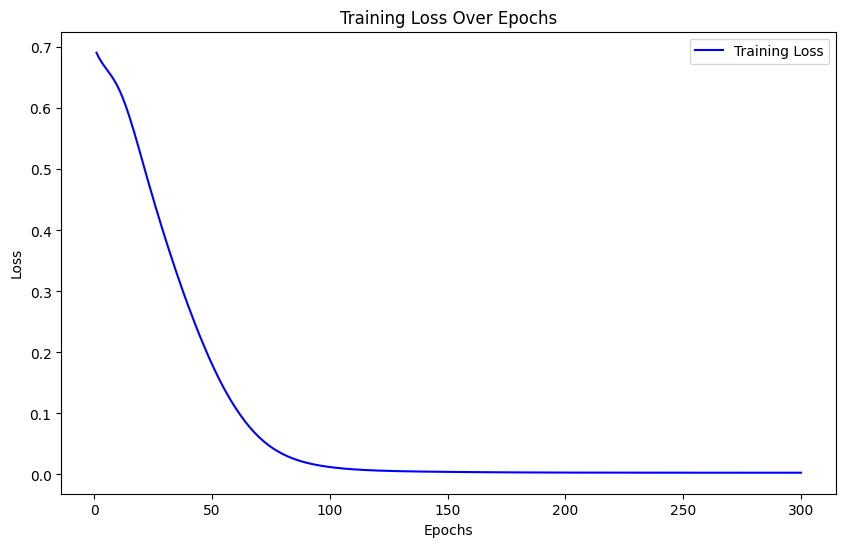

In [31]:
# Loss Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

## Testing

In [32]:
# TESTING
model.eval() 

all_labels = []
all_predictions = []
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:                            # Iterate over each batch (i.e. one patient)
        patient_features = data.x                       # Get features (shape: [num_nodes, in_channels])
        patient_edges = data.edge_index                 # Get edges (shape: [2, num_edges])
        patient_label = data.y.float()                  # Get label (shape: [1])

        # Ensure correct format
        patient_features = patient_features.float()    
        patient_edges = patient_edges.to(torch.long)

        # Forward pass
        output = model(patient_features, patient_edges, data.batch)  # Use the batch info to aggregate across nodes

        # Apply sigmoid to the output logits and get the predicted class (0 or 1)
        pred = torch.sigmoid(output.squeeze())
        predicted_class = (pred >= 0.5).float()                     # Threshold at 0.5 to classify as 0 or 1
        
        # Collect the labels and predictions for metrics
        all_labels.append(patient_label.cpu().numpy())
        all_predictions.append(predicted_class.cpu().numpy())

        # Count correct predictions
        correct += (predicted_class == patient_label).sum().item()
        total += patient_label.size(0)  # Increment by the number of samples in this batch

# Accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

# Calculate Metrics
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
roc_auc = roc_auc_score(all_labels, all_predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

Test Accuracy: 71.42857142857143%
Precision: 0.6153846153846154
Recall: 0.8888888888888888
F1-Score: 0.7272727272727273


## Experiments
Test classification with clinical and image embeddings only

In [33]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout=0.5):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)
        self.dropout = torch.nn.Dropout(p=dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)             # Binary classification
        return x

In [34]:
# Experiment: Train Clinical-only and Image-only Models
for modality, feature_set in [('Clinical', train_clinical_embeddings), ('Image', train_image_features)]:
    print(f"\nTraining {modality}-Only Model")
    
    train_labels = train_labels.clone().detach().float().view(-1, 1)
    test_labels = test_labels.clone().detach().float().view(-1, 1)
    train_features = torch.tensor(feature_set.reshape(len(feature_set), -1))
    test_features = torch.tensor((test_clinical_embeddings if modality == 'Clinical' else test_image_features).reshape(len(test_labels), -1))

    print("Train Features: ", train_features.shape)
    print("Test Features: ", test_features.shape)
    print("Train Labels: ", train_labels.shape)
    print("Test Labels: ", test_labels.shape)
    
    train_dataset = TensorDataset(train_features, train_labels)
    test_dataset = TensorDataset(test_features, test_labels)
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    model = MLP(input_dim=train_features.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=w_decay)
    
    epochs = 100
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for features, labels in train_loader:
            optimizer.zero_grad()
            output = model(features.float())

            loss = torch.nn.BCEWithLogitsLoss()(output.view(-1), labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss/len(train_loader)}")
    
    model.eval()
    all_labels, all_predictions = [], []
    correct = 0
    total = 0

    with torch.no_grad():
        for features, labels in test_loader:
            output = model(features.float())

            pred = torch.sigmoid(output.squeeze()) >= 0.5
            
            all_labels.append(labels.cpu().numpy().flatten())
            all_predictions.append(pred.cpu().numpy().flatten())

            # Count correct predictions
            correct += (pred == labels).sum().item()
            total += labels.size(0)  # Increment by the number of samples in this batch
    
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    print(f"{modality}-Only Model - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    # Accuracy
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy}%")

    # Calculate Metrics
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    roc_auc = roc_auc_score(all_labels, all_predictions)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")


Training Clinical-Only Model
Train Features:  torch.Size([84, 4864])
Test Features:  torch.Size([21, 4864])
Train Labels:  torch.Size([84, 1])
Test Labels:  torch.Size([21, 1])


c:\Users\Usama.Khatab\Projects\miniconda3\envs\hackathon\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/100, Loss: 0.8014376720502263
Epoch 2/100, Loss: 0.7281884278747297
Epoch 3/100, Loss: 0.6162609041535428
Epoch 4/100, Loss: 0.6223313288674468
Epoch 5/100, Loss: 0.6017956584692001
Epoch 6/100, Loss: 0.6325822452005619
Epoch 7/100, Loss: 0.503720065488735
Epoch 8/100, Loss: 0.5169264074387944
Epoch 9/100, Loss: 0.5192441181380196
Epoch 10/100, Loss: 0.538801854526225
Epoch 11/100, Loss: 0.5101282863428683
Epoch 12/100, Loss: 0.5285119785528097
Epoch 13/100, Loss: 0.48135380404086653
Epoch 14/100, Loss: 0.42032575907762204
Epoch 15/100, Loss: 0.4324665805295462
Epoch 16/100, Loss: 0.42884032079321815
Epoch 17/100, Loss: 0.3537601176732486
Epoch 18/100, Loss: 0.43218649479659427
Epoch 19/100, Loss: 0.3732460112376083
Epoch 20/100, Loss: 0.3934940798879844
Epoch 21/100, Loss: 0.29508530954869155
Epoch 22/100, Loss: 0.35038516664904557
Epoch 23/100, Loss: 0.34043467520747245
Epoch 24/100, Loss: 0.3102366478214576
Epoch 25/100, Loss: 0.3286075343212793
Epoch 26/100, Loss: 0.3360646

C:\Users\Usama.Khatab\AppData\Local\Temp\ipykernel_53284\1274329738.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(feature_set.reshape(len(feature_set), -1))
C:\Users\Usama.Khatab\AppData\Local\Temp\ipykernel_53284\1274329738.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_features = torch.tensor((test_clinical_embeddings if modality == 'Clinical' else test_image_features).reshape(len(test_labels), -1))
c:\Users\Usama.Khatab\Projects\miniconda3\envs\hackathon\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1/100, Loss: 0.6866854166700727
Epoch 2/100, Loss: 0.639976177187193
Epoch 3/100, Loss: 0.5967240376131875
Epoch 4/100, Loss: 0.5475654712035543
Epoch 5/100, Loss: 0.5062770669658979
Epoch 6/100, Loss: 0.4465869438080561
Epoch 7/100, Loss: 0.38965034892871264
Epoch 8/100, Loss: 0.34367997979833964
Epoch 9/100, Loss: 0.2988298810308888
Epoch 10/100, Loss: 0.25975156477874234
Epoch 11/100, Loss: 0.21104901381546542
Epoch 12/100, Loss: 0.18513008011948495
Epoch 13/100, Loss: 0.15892977817427545
Epoch 14/100, Loss: 0.13063457914228951
Epoch 15/100, Loss: 0.11774414992846903
Epoch 16/100, Loss: 0.10212992045230099
Epoch 17/100, Loss: 0.09561726632749751
Epoch 18/100, Loss: 0.07826983893201464
Epoch 19/100, Loss: 0.0694471117153409
Epoch 20/100, Loss: 0.06277466272669179
Epoch 21/100, Loss: 0.05312046602678796
Epoch 22/100, Loss: 0.04540835405212073
Epoch 23/100, Loss: 0.03908882886614828
Epoch 24/100, Loss: 0.03972297338657968
Epoch 25/100, Loss: 0.03757062776102906
Epoch 26/100, Loss